In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import tempfile
from itertools import islice
import xml.etree.ElementTree as ET
from lxml import etree
import io
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import imageio.v2 as imageio
import subprocess
import os
import webdataset as wds

In [3]:
def draw_rectangle(top, left, bottom, right, color="red", width=1):
  rect = Rectangle((left, top), width=right - left, height=bottom - top, color=color, linewidth=width, fill=False)
  plt.gca().add_patch(rect)

class Bbox:
    def __init__(self, t=0, l=0, b=0, r=0, from_dict=None):
        if from_dict is not None:
            self.t = from_dict["t"]
            self.l = from_dict["l"]
            self.b = from_dict["b"]
            self.r = from_dict["r"]
        else:
            self.t = t
            self.l = l
            self.b = b
            self.r = r
    def draw_rect(self, color="red", width=1):
        draw_rectangle(self.t, self.l, self.b, self.r, color=color, width=width)
    def __eq__(self, other):
        return self.t == other.t and self.l == other.l and self.b == other.b and self.r == other.r
    def __repr__(self):
        return "Bbox(%d, %d, %d, %d)" % (self.t, self.l, self.b, self.r)
    def __str__(self):
        return self.__repr__()
    def union(self, other):
        return Bbox(
            min(self.t, other.t),
            min(self.l, other.l),
            max(self.b, other.b),
            max(self.r, other.r),
        )
    def grow(self, margin, max_w=9999999, max_h=9999999):
        if not isinstance(margin, tuple):
            margin = (margin, margin, margin, margin)
        return Bbox(
            max(0, self.t - margin[0]),
            max(0, self.l - margin[1]),
            min(max_h, self.b + margin[2]),
            min(max_w, self.r + margin[3]),
        )

    def shrink(self, margin, min_w=1, min_h=1):
        if not isinstance(margin, tuple):
            margin = (margin, margin, margin, margin)
        t = self.t + margin[0]
        l = self.l + margin[1] 
        b = self.b - margin[2]
        r = self.r - margin[3]

        if b - t < min_h:
            diff = min_h - (b - t)
            t -= diff // 2
            b += (diff + 1) // 2

        if r - l < min_w:
            diff = min_w - (r - l)
            l -= diff // 2
            r += (diff + 1) // 2

        return Bbox(t, l, b, r)
    
    def fill(self, nda, value):
        nda[self.t:self.b, self.l:self.r] = value

    def extract(self, nda):
        return nda[self.t:self.b, self.l:self.r, ...]


def splitat(lst, predicate):
    sublists = []
    start = 0
    for i, x in enumerate(lst):
        if predicate(x):
            sublists.append(lst[start:i])
            start = i
    sublists.append(lst[start:])
    return sublists


def gettext(l):
    return "".join(x.text for x in l)

def getbbox(elts):
    l = min(int(x.get("l")) for x in elts)
    t = min(int(x.get("t")) for x in elts)
    b = max(int(x.get("b")) for x in elts)
    r = max(int(x.get("r")) for x in elts)
    return dict(l=l, t=t, b=b, r=r)

def removespace(chars):
    return [c for c in chars if c.text != " "]


def parse_abbyy(file_path, max_pages=9999999):
    parser = etree.XMLParser(recover=True) # Recover from bad characters.
    tree = ET.parse(file_path, parser=parser)
    root = tree.getroot()

    namespace = root.tag.split('}')[0].strip('{')
    namespace
    prefix = f"{{{namespace}}}"

    result = []
    for page in islice(root.findall(prefix+"page"), 0, 9999):
        if len(result) >= max_pages:
            break
        pw, ph = int(page.get("width")), int(page.get("height"))
        rpage = dict(
            size=dict(w=pw, h=ph),
            lines=[],
            words=[],
        )
        for line in page.findall(".//"+prefix+"line"):
            chars = [cp for cp in line.findall(".//"+prefix+"charParams")]
            if len(chars) == 0:
                continue
            rline = getbbox(chars)
            rline["text"] = gettext(chars)
            rpage["lines"].append(rline)
            words = splitat(chars, lambda x: x.get("wordStart")=="true")
            words = map(removespace, words)
            words = [w for w in words if len(w) > 0]
            rwords = [dict(getbbox(w), text=gettext(w)) for w in words]
            rpage["words"] += rwords
        chars = [dict(t=int(x.get("t")), b=int(x.get("b")), l=int(x.get("l")), r=int(x.get("r")), text=x.text) for x in page.findall(".//"+prefix+"charParams")]
        rpage["chars"] = chars
        result.append(rpage)
    return result

In [4]:
class Jp2Zip:
    def __init__(self, fname):
        # fname = f"iadownloads/{base}.zip"
        self.zf = zipfile.ZipFile(fname)
        self.jp2s = sorted([x for x in self.zf.namelist() if x.endswith('.jp2')])
        self.pages = {int(x[-8:-4]): x for x in self.jp2s}
    def __len__(self):
        return len(self.pages.keys())
    def __getitem__(self, i):
        fname = self.pages[i]
        with self.zf.open(fname) as f:
            image = imageio.imread(f)
        return image

In [5]:
def make_page_mask(page, elts):
    mask = np.zeros((page["size"]["h"], page["size"]["w"]), dtype=np.uint8)
    for elt in elts:
        bbox = Bbox(from_dict=elt)
        bbox.grow(3).fill(mask, 1)
        bbox.shrink(2).fill(mask, 2)
        bbox.shrink((200, 5, 200, 5)).grow(3).fill(mask, 3)
    return mask

In [6]:
import glob
import random

downloaded = glob.glob("iadownloads/*.json")
bases = [os.path.basename(x)[:-5] for x in downloaded]

print(f"got {len(bases)} downloaded")

base = random.choice(bases)
print(base)

got 16 downloaded
ERIC_ED010547


In [7]:
import zipfile
import gzip

xmldata = gzip.open(f"iadownloads/{base}.abbyy.gz", "r").read().decode("utf-8")
zipdata = open(f"iadownloads/{base}.zip", "rb").read()

In [8]:
pages = parse_abbyy(io.StringIO(xmldata))
print(len(pages))

zf = Jp2Zip(io.BytesIO(zipdata))
print(len(zf))


295
295


In [9]:
pageno = random.randrange(0, len(pages))
pages[pageno]["size"], zf[pageno].shape

({'w': 6400, 'h': 8896}, (8896, 6400, 3))

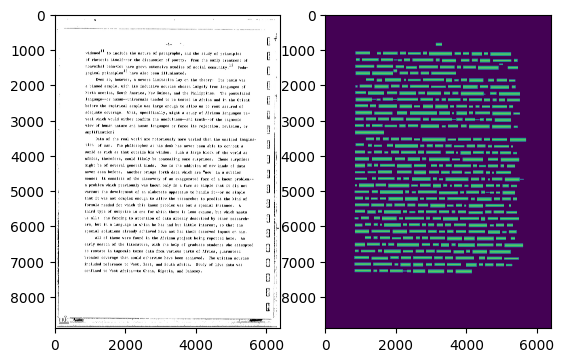

In [10]:
image = zf[pageno]
mask = make_page_mask(pages[pageno], pages[pageno]["words"])
subplot(121); imshow(image)
subplot(122); imshow(mask)

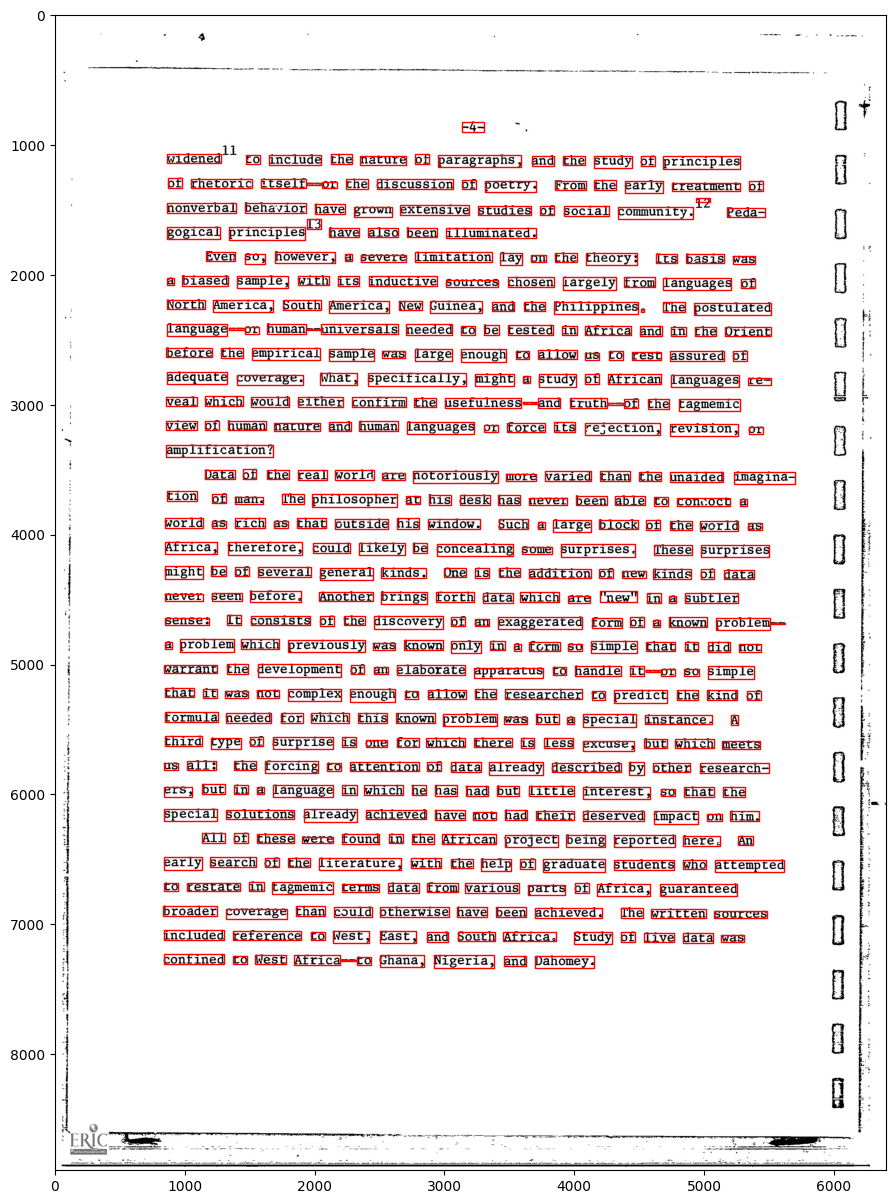

In [11]:
figsize(15, 15)
mask = make_page_mask(pages[pageno], pages[pageno]["words"])
imshow(image, cmap=cm.gray)
for w in pages[10]["words"]:
    bbox = Bbox(from_dict=w)
    bbox.draw_rect()


In [ ]:
# TODO: scale down very large pages